In [1]:
pip install nibabel matplotlib pillow vtk mayavi PyQt5 ipyvolume

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 39.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 85.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 63.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.3/229.3 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.9/268.9 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 97.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 75.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.1/338.1 kB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 MB 9

<ipython-input-3-9adce9c14501>:12: RuntimeWarning: invalid value encountered in divide
  slice = (slice - np.min(slice)) / (np.max(slice) - np.min(slice))  # Normalize to 0-1


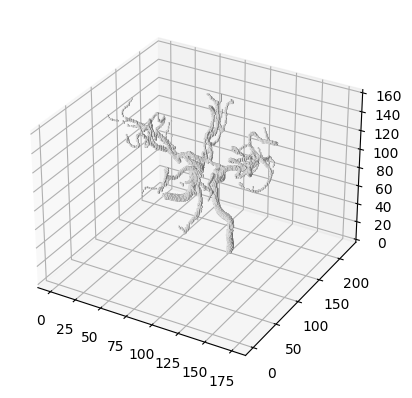

In [3]:
import nibabel as nib
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
from skimage.transform import resize


def normalize_slice(slice):
    """ Normalize the image slice for PNG conversion. """
    slice = (slice - np.min(slice)) / (np.max(slice) - np.min(slice))  # Normalize to 0-1
    slice *= 255  # Scale to 0-255
    return slice.astype(np.uint8)

def nii_to_png(nii_file, output_folder):
    # Load the .nii.gz file
    img = nib.load(nii_file)
    data = img.get_fdata()

    # Create output directory if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Convert each slice to a .png file
    for i in range(data.shape[2]):
        slice = data[:, :, i]
        normalized_slice = normalize_slice(slice)
        img = Image.fromarray(normalized_slice)
        img.save(f"{output_folder}/slice_{i:03}.png")


def is_white(pixel, threshold=245):
    """ Check if the pixel value is above the given threshold. """
    return pixel > threshold

def load_slices_to_voxel_array(output_folder, downsample_factor=2):
    # List all .png files and sort them
    files = [f for f in os.listdir(output_folder) if f.endswith('.png')]
    files.sort()

    # Assuming all slices are of the same dimensions
    first_img = Image.open(os.path.join(output_folder, files[0]))
    original_size = first_img.size  # (width, height)
    downsampled_size = (original_size[1] // downsample_factor, original_size[0] // downsample_factor)
    num_slices = len(files)

    # Create a 3D array (voxel grid)
    voxel_grid = np.zeros((downsampled_size[0], downsampled_size[1], num_slices), dtype=bool)

    # Populate the voxel grid
    for i, file in enumerate(files):
        img = Image.open(os.path.join(output_folder, file))
        img = img.convert('L')  # Convert to grayscale
        img_array = np.array(img)

        # Downsample the image array
        # Note that the resize function takes shape in the order of (rows, cols) or (height, width)
        img_array_downsampled = resize(img_array, (downsampled_size[0], downsampled_size[1]), order=0, anti_aliasing=False, preserve_range=True)

        # Threshold the image to create a binary mask where white is True
        voxel_grid[:, :, i] = img_array_downsampled > 245  # Adjust threshold as needed

    return voxel_grid

def plot_voxel_grid(voxel_grid):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Display the 3D voxel grid without specifying edgecolor to speed up the plot
    ax.voxels(voxel_grid, facecolors='white')

    plt.show()



# Example usage
nii_file = '/content/sub-000_ses-20110101_desc-angio_N4bfc_brain_mask.nii.gz'
output_folder = '/content/pngs'
nii_to_png(nii_file, output_folder)
voxel_grid = load_slices_to_voxel_array(output_folder)
plot_voxel_grid(voxel_grid)


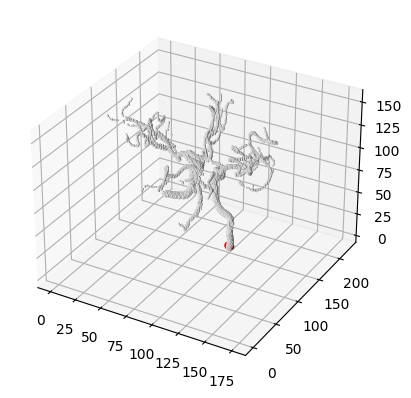

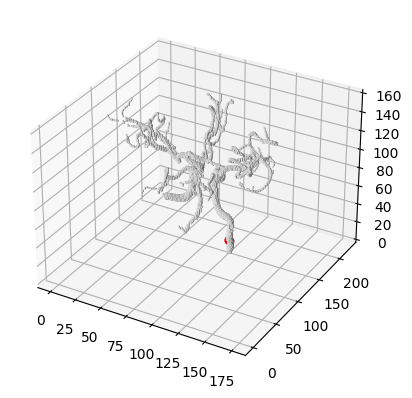

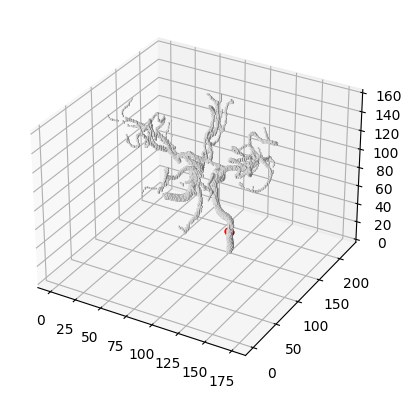

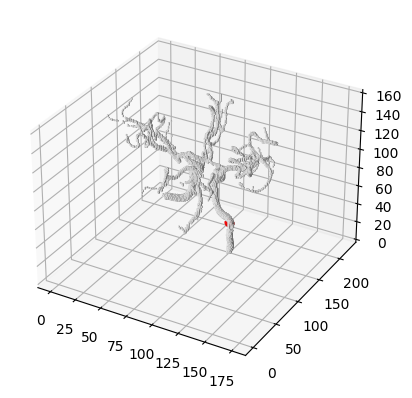

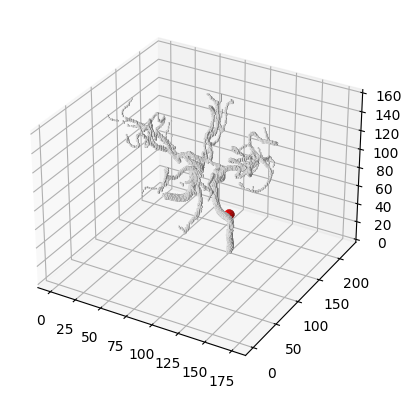

In [ ]:
import nibabel as nib
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import os
from skimage.transform import resize
import time
%matplotlib inline

def normalize_slice(slice):
    """ Normalize the image slice for PNG conversion. """
    slice = (slice - np.min(slice)) / (np.max(slice) - np.min(slice))  # Normalize to 0-1
    slice *= 255  # Scale to 0-255
    return slice.astype(np.uint8)

def nii_to_png(nii_file, output_folder):
    # Load the .nii.gz file
    img = nib.load(nii_file)
    data = img.get_fdata()

    # Create output directory if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Convert each slice to a .png file
    for i in range(data.shape[2]):
        slice = data[:, :, i]
        normalized_slice = normalize_slice(slice)
        img = Image.fromarray(normalized_slice)
        img.save(f"{output_folder}/slice_{i:03}.png")


def is_white(pixel, threshold=245):
    """ Check if the pixel value is above the given threshold. """
    return pixel > threshold

def load_slices_to_voxel_array(output_folder, downsample_factor=2):
    # List all .png files and sort them
    files = [f for f in os.listdir(output_folder) if f.endswith('.png')]
    files.sort()

    # Assuming all slices are of the same dimensions
    first_img = Image.open(os.path.join(output_folder, files[0]))
    original_size = first_img.size  # (width, height)
    downsampled_size = (original_size[1] // downsample_factor, original_size[0] // downsample_factor)
    num_slices = len(files)

    # Create a 3D array (voxel grid)
    voxel_grid = np.zeros((downsampled_size[0], downsampled_size[1], num_slices), dtype=bool)

    # Populate the voxel grid
    for i, file in enumerate(files):
        img = Image.open(os.path.join(output_folder, file))
        img = img.convert('L')  # Convert to grayscale
        img_array = np.array(img)

        # Downsample the image array
        # Note that the resize function takes shape in the order of (rows, cols) or (height, width)
        img_array_downsampled = resize(img_array, (downsampled_size[0], downsampled_size[1]), order=0, anti_aliasing=False, preserve_range=True)

        # Threshold the image to create a binary mask where white is True
        voxel_grid[:, :, i] = img_array_downsampled > 245  # Adjust threshold as needed

    return voxel_grid

def plot_voxel_grid(voxel_grid):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Display the 3D voxel grid without specifying edgecolor to speed up the plot
    ax.voxels(voxel_grid, facecolors='white')

    plt.show()




def plot_voxel_grid(voxel_grid, sphere_center=(50, 50, 50), sphere_radius=4.5):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Display the 3D voxel grid without specifying edgecolor to speed up the plot
    ax.voxels(voxel_grid, facecolors='white')

    # Create a sphere at the specified center
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = sphere_center[0] + sphere_radius * np.cos(u) * np.sin(v)
    y = sphere_center[1] + sphere_radius * np.sin(u) * np.sin(v)
    z = sphere_center[2] + sphere_radius * np.cos(v)
    ax.plot_surface(x, y, z, color='r')

    plt.show()

# Example usage
#nii_file = '/content/sub-000_ses-20110101_desc-brain_mask.nii.gz'  # Update with the correct file path
#output_folder = '/content/pngs'    # Update with the correct folder path
#nii_to_png(nii_file, output_folder)
#voxel_grid = load_slices_to_voxel_array(output_folder)

step_size= 10
n_frames = 10
for i in range(0, n_frames):
    c1 = (100 , 150, 0+i * step_size)
    plot_voxel_grid(voxel_grid, c1)
    #time.sleep(1)


In [ ]:
import ipyvolume as ipv
import numpy as np
import os
from PIL import Image

def load_slices_to_points(output_folder, threshold=245):
    # List all .png files and sort them
    files = [f for f in os.listdir(output_folder) if f.endswith('.png')]
    files.sort()

    # Collect points from each slice
    points = []
    for i, file in enumerate(files):
        img = Image.open(os.path.join(output_folder, file))
        img = img.convert('L')  # Convert to grayscale
        img_array = np.asarray(img)

        # Find the white points
        y, x = np.where(img_array > threshold)
        z = np.ones_like(x) * i
        points.append(np.vstack((x, y, z)).T)

    # Combine all points from all slices into a single array
    points = np.vstack(points)
    return points

def plot_with_ipyvolume(points, size=0.3):  # Reduced size for potentially better detail visibility
    # Normalize the points to the range 0-1 for plotting
    min_vals = points.min(axis=0)
    max_vals = points.max(axis=0)
    normalized_points = (points - min_vals) / (max_vals - min_vals)

    # Create a 3D scatter plot with a uniform bright green color
    ipv.figure()
    scatter = ipv.scatter(normalized_points[:,0], normalized_points[:,1], normalized_points[:,2],
                          marker='sphere', size=size,
                          color='lime', opacity=0.75)  # Set color to bright green

    # Set a dark background to contrast the bright green points
    ipv.style.use('dark')

    # Show the figure
    ipv.show()

# Replace with the path to your folder containing the PNG files
output_folder = '/content/pngs'  # make sure this is the correct path
points = load_slices_to_points(output_folder)
plot_with_ipyvolume(points)


Html(layout=None, style_='display: none', tag='span')

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [ ]:
import ipyvolume as ipv
import numpy as np


def load_slices_to_points(output_folder, threshold=245):
    # List all .png files and sort them
    files = [f for f in os.listdir(output_folder) if f.endswith('.png')]
    files.sort()

    # Collect points from each slice
    points = []
    for i, file in enumerate(files):
        img = Image.open(os.path.join(output_folder, file))
        img = img.convert('L')  # Convert to grayscale
        img_array = np.asarray(img)

        # Find the white points
        y, x = np.where(img_array > threshold)
        z = np.ones_like(x) * i
        points.append(np.vstack((x, y, z)).T)

    # Combine all points from all slices into a single array
    points = np.vstack(points)
    return points
# Function to plot points in a scatter plot
def plot_with_ipyvolume(points, size=0.3):  # Reduced size for potentially better detail visibility
    # Normalize the points to the range 0-1 for plotting
    min_vals = points.min(axis=0)
    max_vals = points.max(axis=0)
    normalized_points = (points - min_vals) / (max_vals - min_vals)

    # Create a 3D scatter plot with a uniform bright green color
    ipv.figure()
    scatter = ipv.scatter(normalized_points[:,0], normalized_points[:,1], normalized_points[:,2],
                          marker='sphere', size=size,
                          color='lime', opacity=0.75)  # Set color to bright green

    # Set a dark background to contrast the bright green points
    ipv.style.use('dark')


# Function to create the lines of a box given two opposite corners
def create_box(c1, c2, color='#3e23eb'):
    # Define the vertices of the box
    v = np.array([[c1[0], c1[1], c1[2]],  # v0
                  [c2[0], c1[1], c1[2]],  # v1
                  [c2[0], c2[1], c1[2]],  # v2
                  [c1[0], c2[1], c1[2]],  # v3
                  [c1[0], c1[1], c2[2]],  # v4
                  [c2[0], c1[1], c2[2]],  # v5
                  [c2[0], c2[1], c2[2]],  # v6
                  [c1[0], c2[1], c2[2]]]) # v7

    # Define the lines by vertices
    lines = np.array([[v[0], v[1]],
                      [v[1], v[2]],
                      [v[2], v[3]],
                      [v[3], v[0]],
                      [v[4], v[5]],
                      [v[5], v[6]],
                      [v[6], v[7]],
                      [v[7], v[4]],
                      [v[0], v[4]],
                      [v[1], v[5]],
                      [v[2], v[6]],
                      [v[3], v[7]]])

    # Draw the lines
    for line in lines:
        x, y, z = zip(*line)
        ipv.plot(x, y, z, color=color)
def update_box_figure(points, c1, c2, step=0.01):
    ipv.clear()  # Clear the current figure
    plot_with_ipyvolume(points)  # Redraw the points
    create_box(c1,c2)
    ipv.show()
# Replace with the path to your folder containing the PNG files
output_folder = '/content/pngs'  # make sure this is the correct path
points = load_slices_to_points(output_folder)
plot_with_ipyvolume(points)



a, b, c = 0.59, 0.65, 0.001
offseta, offsetb, offsetc = 0.02, 0.025, 0.02
c1 = (a, b, c)  # Coordinates for corner 1
c2 = (a+offseta, b+offsetb, c+offsetc)  # Coordinates for corner 2

# Fill the smaller box

# Animate the box
step_size= .05
n_frames = 2
for i in range(0, n_frames):
    c1_new = (c1[0] + i * step_size, c1[1], c1[2])
    c2_new = (c2[0] + i * step_size, c2[1], c2[2])
    update_box_figure(points, c1_new, c2_new, step=step_size)
    time.sleep(1)

Html(layout=None, style_='display: none', tag='span')

Html(layout=None, style_='display: none', tag='span')

Html(layout=None, style_='display: none', tag='span')

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

Html(layout=None, style_='display: none', tag='span')

Html(layout=None, style_='display: none', tag='span')

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [ ]:
pip install ipyvolume

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 83.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.7/271.7 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 76.8 MB/s eta 0:00:00
